In [1]:
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn import set_config
from sklearn.compose import TransformedTargetRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from torch.utils.data import DataLoader, TensorDataset

from pytorch_helpers import MLP
from sklearn_helpers import (
    get_column_transformer,
    get_preprocessor,
    print_metrics,
    show_coefficients,
)

simplefilter(action="ignore", category=FutureWarning)
sns.set_theme(style="whitegrid")
pd.set_option("precision", 3)
pd.set_option("display.max_columns", 100)
# default value is "text"
set_config(display="diagram")



In [2]:
# SECTION: Analyze Performance on Validation Set during Training
k_best_results = pd.read_pickle("../results-pickle/k_best_results.pkl")
rfe_results = pd.read_pickle("../results-pickle/rfe_results.pkl")
sfm_results = pd.read_pickle("../results-pickle/sfm_results.pkl")
vt_results = pd.read_pickle("../results-pickle/vt_results.pkl")
pca_results = pd.read_pickle("../results-pickle/pca_results.pkl")
full_features_results = pd.read_pickle("../results-pickle/full_features_results.pkl")
neural_network_results = pd.read_pickle("../results-pickle/neural_network_results.pkl")

complete_results = pd.concat(
    [
        k_best_results,
        rfe_results,
        sfm_results,
        vt_results,
        pca_results,
        full_features_results,
        neural_network_results,
    ]
).sort_values("mae_val")

complete_results.to_pickle("../results-pickle/complete_results.pkl")



In [3]:
# SUBSECTION: Analyze Results
complete_results



,mae_train,mae_val,r2_train,r2_val,mse_train,mse_val,hyperparam_keys,hyperparam_values,num_features,feature_selector,log_y
NeuralNetwork,596.024,391.825,0.200,0.207,1.369e+06,9.060e+05,"[batch_size, num_epochs, learning_rate, dropou...","[128, 200, 0.01, 0.5]",40.0,None,False
HistGradientBoostingRegressor,337.226,412.232,0.405,0.274,9.799e+05,1.305e+06,"[min_samples_leaf, max_leaf_nodes, max_iter, m...","[10, 30, 30, 12, 0.09]",20.0,RFE,True
HistGradientBoostingRegressor,359.609,413.547,0.376,0.270,1.028e+06,1.311e+06,"[min_samples_leaf, max_leaf_nodes, max_iter, m...","[6, 15, 40, 24, 0.06999999999999999]",57.0,None,True
Ridge,403.192,413.629,0.228,0.261,1.272e+06,1.297e+06,alpha,10,57.0,None,True
LinearRegression,401.190,414.093,0.232,0.262,1.265e+06,1.294e+06,None,None,57.0,None,True
...,...,...,...,...,...,...,...,...,...,...,...
Lasso,568.482,568.715,-0.035,-0.048,1.703e+06,1.702e+06,alpha,14,30.0,PCA,True
Lasso,568.482,568.715,-0.035,-0.048,1.703e+06,1.702e+06,alpha,14,14.0,VarianceThreshold,True
Lasso,568.482,568.715,-0.035,-0.048,1.703e+06,1.702e+06,alpha,14,57.0,None,True
Lasso,568.482,568.715,-0.035,-0.048,1.703e+06,1.702e+06,alpha,14,10.0,SelectKBest,True


In [4]:
# Baseline Performance
complete_results.loc["Mean Prediction"]


,mae_train,mae_val,r2_train,r2_val,mse_train,mse_val,hyperparam_keys,hyperparam_values,num_features,feature_selector,log_y
Mean Prediction,568.497,568.497,-0.035,-0.035,1.703e+06,1.703e+06,None,None,NaN,None,True
Mean Prediction,629.790,629.790,0.000,0.000,1.645e+06,1.645e+06,None,None,NaN,None,False


In [5]:
complete_results.sort_values("r2_val", ascending=False)



,mae_train,mae_val,r2_train,r2_val,mse_train,mse_val,hyperparam_keys,hyperparam_values,num_features,feature_selector,log_y
HistGradientBoostingRegressor,337.226,412.232,0.405,0.274,9.799e+05,1.305e+06,"[min_samples_leaf, max_leaf_nodes, max_iter, m...","[10, 30, 30, 12, 0.09]",20.0,RFE,True
HistGradientBoostingRegressor,379.907,415.810,0.315,0.272,1.128e+06,1.307e+06,"[min_samples_leaf, max_leaf_nodes, max_iter, m...","[6, 15, 40, 24, 0.06999999999999999]",10.0,RFE,True
HistGradientBoostingRegressor,380.894,416.598,0.314,0.270,1.130e+06,1.309e+06,"[min_samples_leaf, max_leaf_nodes, max_iter, m...","[6, 15, 40, 24, 0.06999999999999999]",10.0,SelectFromModel,True
HistGradientBoostingRegressor,359.609,413.547,0.376,0.270,1.028e+06,1.311e+06,"[min_samples_leaf, max_leaf_nodes, max_iter, m...","[6, 15, 40, 24, 0.06999999999999999]",57.0,None,True
RandomForestRegressor,400.382,427.700,0.299,0.266,1.154e+06,1.308e+06,"[n_estimators, min_samples_leaf, max_depth]","[5, 4, 5]",10.0,SelectFromModel,True
...,...,...,...,...,...,...,...,...,...,...,...
Lasso,568.482,568.715,-0.035,-0.048,1.703e+06,1.702e+06,alpha,14,30.0,RFE,True
Lasso,568.482,568.715,-0.035,-0.048,1.703e+06,1.702e+06,alpha,14,20.0,RFE,True
Lasso,568.482,568.715,-0.035,-0.048,1.703e+06,1.702e+06,alpha,14,20.0,SelectKBest,True
Lasso,568.482,568.715,-0.035,-0.048,1.703e+06,1.702e+06,alpha,14,10.0,RFE,True


In [6]:
# stratified by log_y
complete_results.groupby("log_y").apply(lambda x: x.nsmallest(3, "mae_val"))



mae_train  mae_val  r2_train  r2_val  \
log_y                                                                       
False NeuralNetwork                    596.024  391.825     0.200   0.207   
      HistGradientBoostingRegressor    400.469  461.282     0.526   0.240   
      HistGradientBoostingRegressor    398.779  462.363     0.536   0.233   
True  HistGradientBoostingRegressor    337.226  412.232     0.405   0.274   
      HistGradientBoostingRegressor    359.609  413.547     0.376   0.270   
      Ridge                            403.192  413.629     0.228   0.261   

                                     mse_train    mse_val  \
log_y                                                       
False NeuralNetwork                  1.369e+06  9.060e+05   
      HistGradientBoostingRegressor  7.796e+05  1.321e+06   
      HistGradientBoostingRegressor  7.640e+05  1.330e+06   
True  HistGradientBoostingRegressor  9.799e+05  1.305e+06   
      HistGradientBoostingRegressor  1.028e+06  1.311e+06   
      Ridge                          1.272e+06  1.297e+06   

                                                                       hyperparam_keys  \
log_y                                                                                    
False NeuralNetwork                  [batch_size, num_epochs, learning_rate, dropou...   
      HistGradientBoostingRegressor  [min_samples_leaf, max_leaf_nodes, max_iter, m...   
      HistGradientBoostingRegressor  [min_samples_leaf, max_leaf_nodes, max_iter, m...   
True  HistGradientBoostingRegressor  [min_samples_leaf, max_leaf_nodes, max_iter, m...   
      HistGradientBoostingRegressor  [min_samples_leaf, max_leaf_nodes, max_iter, m...   
      Ridge                                                                      alpha   

                                                        hyperparam_values  \
log_y                                                                       
False NeuralNetwork                                 [128, 200, 0.01, 0.5]   
      HistGradientBoostingRegressor  [6, 15, 40, 24, 0.06999999999999999]   
      HistGradientBoostingRegressor  [6, 15, 40, 24, 0.06999999999999999]   
True  HistGradientBoostingRegressor                [10, 30, 30, 12, 0.09]   
      HistGradientBoostingRegressor  [6, 15, 40, 24, 0.06999999999999999]   
      Ridge                                                            10   

                                     num_features feature_selector  log_y  
log_y                                                                      
False NeuralNetwork                          40.0             None  False  
      HistGradientBoostingRegressor          10.0  SelectFromModel  False  
      HistGradientBoostingRegressor          10.0              RFE  False  
True  HistGradientBoostingRegressor          20.0              RFE   True  
      HistGradientBoostingRegressor          57.0             None   True  
      Ridge                                  57.0             None   True

In [7]:
complete_results.groupby("log_y").apply(lambda x: x.nlargest(3, "r2_val"))



mae_train  mae_val  r2_train  r2_val  \
log_y                                                                       
False HistGradientBoostingRegressor    443.552  467.190     0.305   0.256   
      HistGradientBoostingRegressor    443.691  466.894     0.309   0.252   
      HistGradientBoostingRegressor    443.475  467.752     0.329   0.249   
True  HistGradientBoostingRegressor    337.226  412.232     0.405   0.274   
      HistGradientBoostingRegressor    379.907  415.810     0.315   0.272   
      HistGradientBoostingRegressor    380.894  416.598     0.314   0.270   

                                     mse_train    mse_val  \
log_y                                                       
False HistGradientBoostingRegressor  1.145e+06  1.318e+06   
      HistGradientBoostingRegressor  1.139e+06  1.321e+06   
      HistGradientBoostingRegressor  1.105e+06  1.328e+06   
True  HistGradientBoostingRegressor  9.799e+05  1.305e+06   
      HistGradientBoostingRegressor  1.128e+06  1.307e+06   
      HistGradientBoostingRegressor  1.130e+06  1.309e+06   

                                                                       hyperparam_keys  \
log_y                                                                                    
False HistGradientBoostingRegressor  [min_samples_leaf, max_leaf_nodes, max_iter, m...   
      HistGradientBoostingRegressor  [min_samples_leaf, max_leaf_nodes, max_iter, m...   
      HistGradientBoostingRegressor  [min_samples_leaf, max_leaf_nodes, max_iter, m...   
True  HistGradientBoostingRegressor  [min_samples_leaf, max_leaf_nodes, max_iter, m...   
      HistGradientBoostingRegressor  [min_samples_leaf, max_leaf_nodes, max_iter, m...   
      HistGradientBoostingRegressor  [min_samples_leaf, max_leaf_nodes, max_iter, m...   

                                                         hyperparam_values  \
log_y                                                                        
False HistGradientBoostingRegressor  [16, 5, 40, 24, 0.060000000000000005]   
      HistGradientBoostingRegressor  [16, 5, 40, 24, 0.060000000000000005]   
      HistGradientBoostingRegressor  [16, 5, 40, 24, 0.060000000000000005]   
True  HistGradientBoostingRegressor                 [10, 30, 30, 12, 0.09]   
      HistGradientBoostingRegressor   [6, 15, 40, 24, 0.06999999999999999]   
      HistGradientBoostingRegressor   [6, 15, 40, 24, 0.06999999999999999]   

                                     num_features   feature_selector  log_y  
log_y                                                                        
False HistGradientBoostingRegressor          17.0    SelectFromModel  False  
      HistGradientBoostingRegressor          20.0                RFE  False  
      HistGradientBoostingRegressor          30.0  VarianceThreshold  False  
True  HistGradientBoostingRegressor          20.0                RFE   True  
      HistGradientBoostingRegressor          10.0                RFE   True  
      HistGradientBoostingRegressor          10.0    SelectFromModel   True

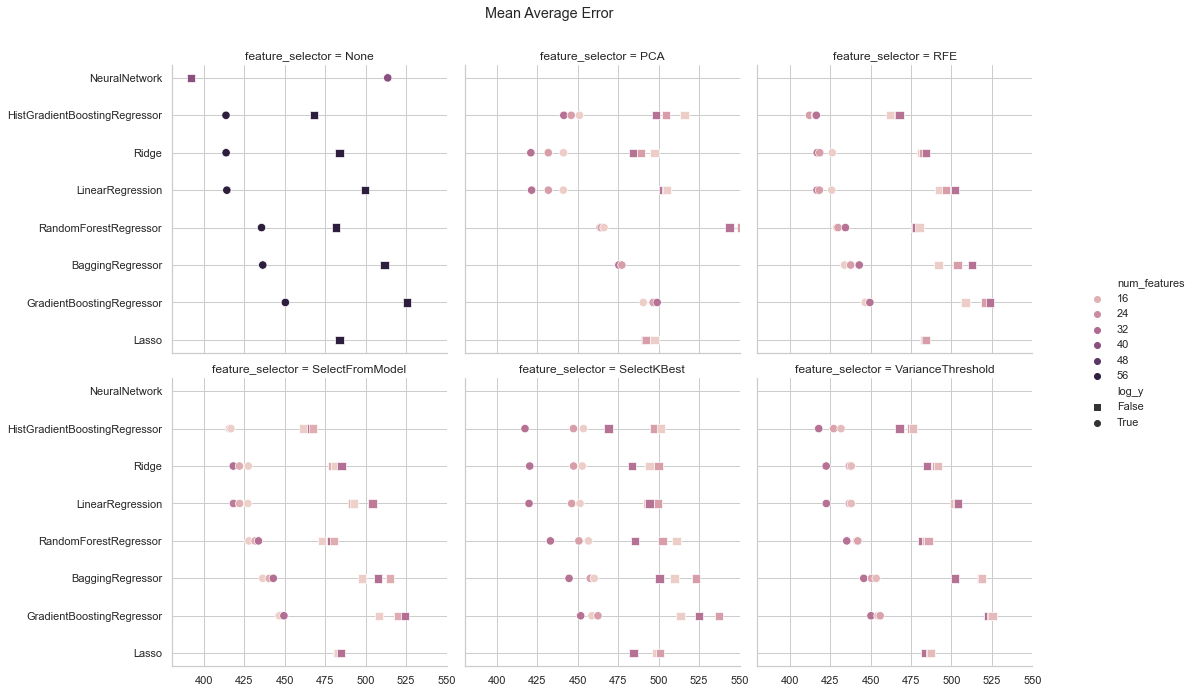

In [8]:
plot_data = complete_results.fillna({"feature_selector": "None"}).astype(
    {"feature_selector": "category"}
)[["mae_val", "r2_val", "num_features", "feature_selector", "log_y"]]

g = sns.relplot(
    data=plot_data,
    x="mae_val",
    y=plot_data.index,
    hue="num_features",
    col="feature_selector",
    col_wrap=3,
    style="log_y",
    markers=["s", "o"],
    s=70,
).set(xlabel="", ylabel="", xlim=(380, 550))

g.fig.suptitle("Mean Average Error")
g.fig.subplots_adjust(top=0.9)

sns.move_legend(obj=g, loc="center", bbox_to_anchor=(1, 0.5), frameon=False)



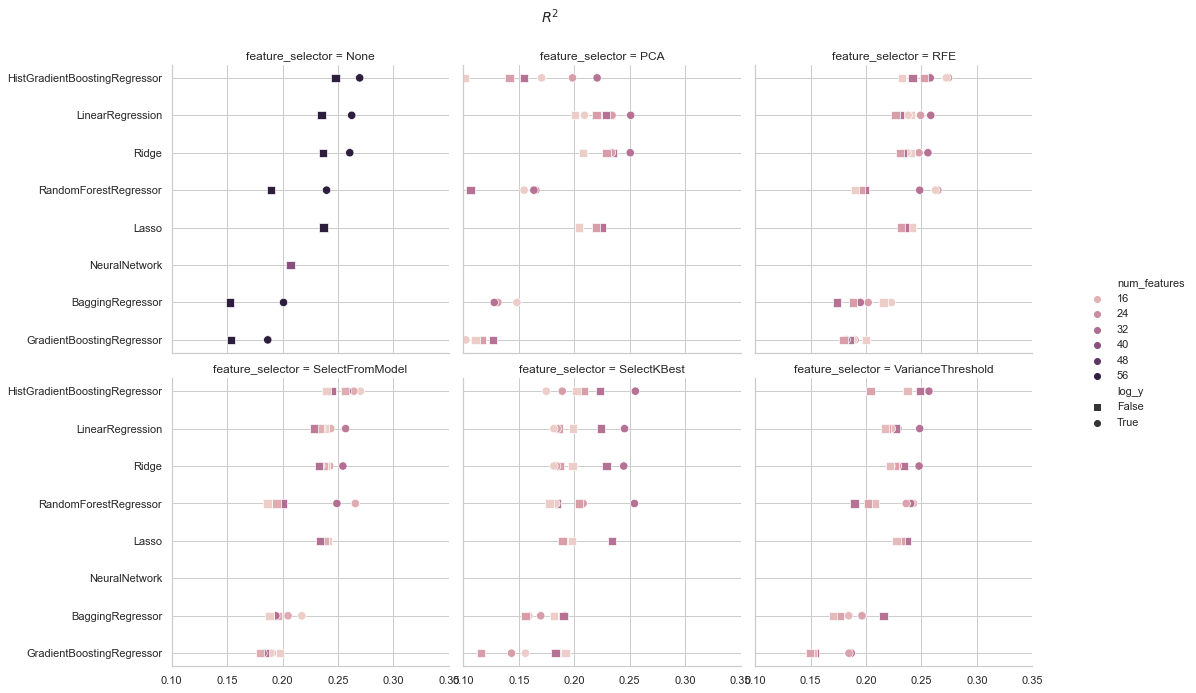

In [9]:
plot_data = plot_data.sort_values("r2_val", ascending=False)

g = sns.relplot(
    data=plot_data,
    x="r2_val",
    y=plot_data.index,
    hue="num_features",
    col="feature_selector",
    col_wrap=3,
    style="log_y",
    markers=["s", "o"],
    s=70,
).set(xlabel="", ylabel="", xlim=(0.1, 0.35))

g.fig.suptitle(r"$R^2$")
g.fig.subplots_adjust(top=0.9)

sns.move_legend(obj=g, loc="center", bbox_to_anchor=(1, 0.5), frameon=False)



In [10]:
# SECTION: Evaluate Performance of Best Models on Test Set
X_train_val = pd.read_pickle("../data-clean/X_train_val.pkl")
y_train_val = pd.read_pickle("../data-clean/y_train_val.pkl")

X_test = pd.read_pickle("../data-clean/X_test.pkl")
y_test = pd.read_pickle("../data-clean/y_test.pkl")



In [11]:
# SUBSECTION: Classical Model with lowest MAE on Validation Set
column_transformer = get_column_transformer()
rfe = RFE(SVR(kernel="linear"), n_features_to_select=30, step=0.5)
preprocessor = get_preprocessor(column_transformer, rfe)

best_model_mae = LinearRegression()
pipeline = make_pipeline(preprocessor, best_model_mae)

# sklearn.set_config(display="diagram") creates nice visual display of pipelines
pipeline


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('column_transformer',
                                  ColumnTransformer(transformers=[('standardscaler',
                                                                   StandardScaler(),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x000001719F1E0CA0>),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(dtype=<class 'int'>,
                                                                                 handle_unknown='ignore'),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x000001719F16D130>)])),
                                 ('feature_selector',
                                  RFE(estimator=SVR(kernel='linear'),
                                      n_features_to_select=30, step=0.5))])),
                ('linearregression', LinearRegression())])

In [12]:
log_transform = TransformedTargetRegressor(pipeline, func=np.log, inverse_func=np.exp)
log_transform.fit(X_train_val, y_train_val)
y_hat_mae = log_transform.predict(X_test)

print_metrics(y_test, y_hat_mae)
coefs_30 = show_coefficients(log_transform)
coefs_30


MAE: 435.567
R^2: 0.210


,feature,coefficient
0,neighbourhood_Sentrum,0.326
1,room_type_Entire home/apt,0.324
2,bedrooms,0.240
3,property_type_Entire villa,0.221
4,neighbourhood_Frogner,0.219
5,neighbourhood_St. Hanshaugen,0.180
6,property_type_Camper/RV,0.175
7,property_type_Entire serviced apartment,0.171
8,neighbourhood_Grünerløkka,0.135
9,neighbourhood_Marka,0.133


In [13]:
# SUBSECTION: Classical Model with lowest R^2 on Validation Set
rfe = RFE(SVR(kernel="linear"), n_features_to_select=20, step=0.5)
preprocessor = get_preprocessor(column_transformer, rfe)

best_model_r2 = LinearRegression()
pipeline = make_pipeline(preprocessor, best_model_r2)
log_transform = TransformedTargetRegressor(pipeline, func=np.log, inverse_func=np.exp)

log_transform.fit(X_train_val, y_train_val)
y_hat_r2 = log_transform.predict(X_test)

print_metrics(y_test, y_hat_r2)
show_coefficients(log_transform)



MAE: 439.230
R^2: 0.205


,feature,coefficient
0,room_type_Entire home/apt,0.342
1,neighbourhood_Sentrum,0.311
2,property_type_Entire villa,0.271
3,bedrooms,0.261
4,neighbourhood_Frogner,0.208
5,neighbourhood_St. Hanshaugen,0.156
6,property_type_Entire serviced apartment,0.151
7,cnn_pretrained_predictions,0.121
8,neighbourhood_Grünerløkka,0.116
9,availability_365,0.106


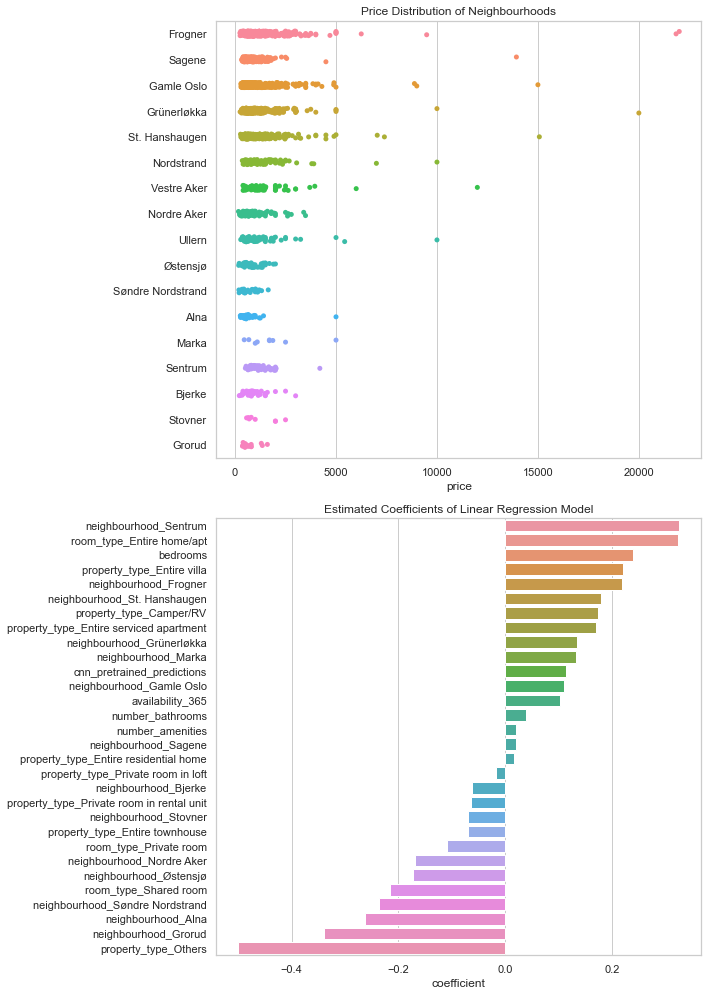

In [14]:
# Neighbourhood has the strongest influence
listings_df = pd.read_pickle("../data-clean/listings_subset.pkl")

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 14))

sns.stripplot(data=listings_df, x="price", y="neighbourhood", ax=ax1).set(
    title="Price Distribution of Neighbourhoods", ylabel=""
)

sns.barplot(data=coefs_30, x="coefficient", y="feature", ax=ax2).set(
    title="Estimated Coefficients of Linear Regression Model", ylabel=""
)

fig.tight_layout()
plt.show()



In [15]:
# SUBSECTION: Neural Network Model
column_transformer = get_column_transformer()
column_transformer.fit(X_train_val)

X_tensor_test = torch.tensor(column_transformer.transform(X_test).astype(np.float32))
y_tensor_test = torch.tensor(y_test.values.astype(np.float32))
testset = TensorDataset(X_tensor_test, y_tensor_test)
testloader = DataLoader(testset, batch_size=X_tensor_test.shape[0])

in_features = X_tensor_test.shape[1]
hidden_features_list = [64, 128, 256, 512, 512, 256, 128, 64, 32, 16, 8]
dropout_prob = 0.5

model = MLP(in_features, hidden_features_list, dropout_prob)
# have to rerun fully_connected.py with updated features 
model.load_state_dict(torch.load("fully_connected_weights.pt"))
model.eval()

with torch.no_grad():
    X_nn, y_nn = next(iter(testloader))
    y_hat_nn = model(X_nn).squeeze()

print_metrics(y_test, y_hat_nn.detach())



RuntimeError: Error(s) in loading state_dict for MLP:
	size mismatch for input_layer.0.weight: copying a param with shape torch.Size([64, 57]) from checkpoint, the shape in current model is torch.Size([64, 58]).

In [ ]:
# SUBSECTION: Plot Predictions vs. True Price
best_model_mae_name = best_model_mae.__class__.__name__
best_model_r2_name = best_model_r2.__class__.__name__
size = 20

range_original = [min(y_test), max(y_test)]
range_log = [min(np.log(y_test)), max(np.log(y_test))]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 12))

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flat

# identity line
ax1.scatter(
    y_test.values, y_hat_mae, label=f"{best_model_mae_name}", s=size, color="blue"
)

ax2.scatter(
    np.log(y_test.values),
    np.log(y_hat_mae),
    label=f"{best_model_mae_name}",
    s=size,
    color="blue",
)

ax3.scatter(
    y_test.values, y_hat_r2, label=f"{best_model_r2_name}", s=size, color="green"
)

ax4.scatter(
    np.log(y_test.values),
    np.log(y_hat_r2),
    label=f"{best_model_r2_name}",
    s=size,
    color="green",
)

ax5.scatter(y_test.values, y_hat_nn, label="Neural Network", s=size, color="orange")

ax6.scatter(
    np.log(y_test.values),
    np.log(y_hat_nn),
    label="Neural Network",
    s=size,
    color="orange",
)

for index, ax in enumerate(axes.flat):
    if index % 2 == 0:
        ax.set(ylabel="Predictions")
        ax.legend()
        # identity line
        ax.plot(range_original, range_original, linestyle="dashed", color="grey")
    else:
        ax.plot(range_log, range_log, linestyle="dashed", color="grey")
    if index == 0:
        ax.set(title="Original Scale")
    if index == 1:
        ax.set(title="Log Scale")
    if index in (4, 5):
        ax.set(xlabel="True Price")

fig.tight_layout()
plt.show()
